In [1]:
import glob
import os
import sys
import librosa
import librosa.display
import librosa.core
import math
import seaborn as sns
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy import signal


import IPython.display
from IPython.display import Video


import pickle
import pdb
import h5py
    
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

%matplotlib inline 

plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

%load_ext autoreload
%autoreload 2

sns.set()
plt.rcParams.update({'font.family':'Times New Roman'})
#============= import for DL audio ============
import matplotlib.pyplot as plt
from scipy.io import wavfile
import argparse
import os
from glob import glob
import numpy as np
import pandas as pd
from librosa.core import resample, to_mono
from tqdm import tqdm

#Import required modules
from sklearn.decomposition import PCA
 


In [2]:
success_file_list = [1,2,3]
fail_file_list = [4]


len_suc = len(success_file_list)
len_fail = len(fail_file_list)

print(f" total len {len_suc+len_fail}")

 total len 4


In [3]:
# load t1~25.npy files and concatenate them into Trial x 5 x Time
def load_npy_files(path_directory, input_file_list):

    total_trials_all_mic = []

    #TODO: iterate through a given file_list
    for item in input_file_list:
        file_name = os.path.join(path_directory, f"t{item}.npy")
        trial_all_mic_audio = np.load(file_name, allow_pickle=True)
        #TODO: append the single_trial into trial_list
        total_trials_all_mic.append(trial_all_mic_audio)

    return total_trials_all_mic


In [4]:
dataset_path = "/rosbag/audio/ISU_audio_dataset/insertion/dataset_field/"
save_directory = "/home/marklee/IAM/vibration_project/ISU_audio_07_2023/dataset_np/"

fs= 44100
total_list = numbers_list = [i for i in range(1, 5)]


# #2. load saved npy files (indices from 1-25)
total_trial_all_mic = load_npy_files(save_directory, total_list)




In [11]:
trial = 4
print(f"total_trial_all_mic_np shape: {len(total_trial_all_mic)}")
print(f"len of audio {len(total_trial_all_mic[trial-1][0])/fs}")
# utils_audio.plot_time_domain_all_mic(total_trial_all_mic,trial-1)

total_trial_all_mic_np shape: 4
len of audio 8.0


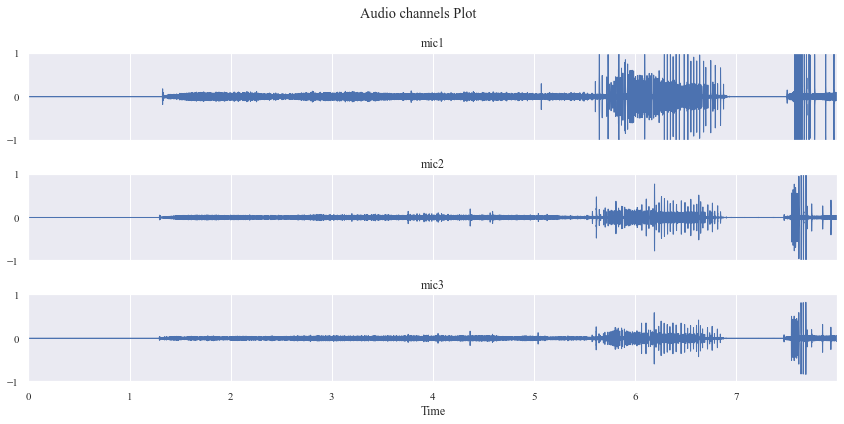

In [12]:
plot_time_domain_all_mic(total_trial_all_mic, trial-1)


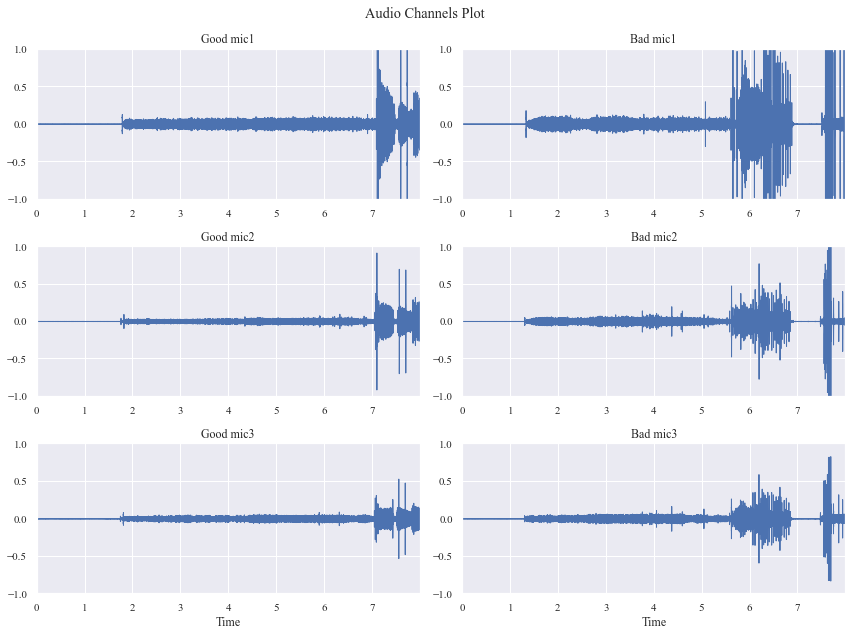

In [13]:
good_trial_index = 0
bad_trial_index = 3
plot_time_domain_good_bad(total_trial_all_mic, good_trial_index, total_trial_all_mic, bad_trial_index, fs)


In [14]:
len(total_trial_all_mic[good_trial_index][0])

352800

In [15]:
IPython.display.Audio(total_trial_all_mic[good_trial_index][0], rate=fs)

In [16]:
IPython.display.Audio(total_trial_all_mic[bad_trial_index][0], rate=fs)

In [47]:
# function to pre-process time length of each list to 6 seconds of audio clip
def trim_audio(input_trials_all_mic, fs, trial_list):
    # input: list of trials, fs sampling freq
    # output: trimmed list of trials

    trimmed_trials_all_mic = []

    # iterate through each trial
    for trial_index, trial in enumerate(input_trials_all_mic):
        trimmed_trial_mic = []

        # pick out 1st array mic out of 5
        first_mic_array = trial[0]

        # detect the first index mic amplitude exceeds 0.5
        exceed_indices = np.where(np.abs(first_mic_array) > 0.15)[0]
        if len(exceed_indices) == 0:
            print(f"found no threshold for trial {trial_list[trial_index]}")
            continue  # If no exceedances, skip this trial

        first_exceed_index = exceed_indices[0]

        # take 3 seconds before and after the detect index
        trim_start = max(0, first_exceed_index - int(fs * 1))
        trim_end = min(len(first_mic_array), first_exceed_index + int(fs * 6))
        
#         # take 3-5.5 seconds after the detect
        trim_start = max(0, first_exceed_index + int(fs * 3))
        trim_end = min(len(first_mic_array), first_exceed_index + int(fs * 5.5))
        

        # trim the remaining mic array within this duration for all mics
        for mic_array in trial:
            trimmed_mic = mic_array[trim_start:trim_end]
            trimmed_trial_mic.append(trimmed_mic)

        trimmed_trials_all_mic.append(trimmed_trial_mic)

    return trimmed_trials_all_mic


In [48]:
good_trimmed_trials_all_mic = trim_audio(good_trial_all_mic,fs,success_file_list)
bad_trimmed_trials_all_mic = trim_audio(bad_trial_all_mic,fs,success_file_list)


In [49]:
print(f"num items: {len(good_trimmed_trials_all_mic), len(bad_trimmed_trials_all_mic), }")
print(f"num mic: {len(good_trimmed_trials_all_mic[0])}")

num items: (23, 24)
num mic: 5


In [8]:
# function to plot time domain and listen 

def plot_time_domain_all_mic(trimmed_trials_all_mic, trial_index):
 
    audio_input1_trim = trimmed_trials_all_mic[trial_index][0]
    audio_input2_trim = trimmed_trials_all_mic[trial_index][1]
    audio_input3_trim = trimmed_trials_all_mic[trial_index][2]
    audio_input4_trim = trimmed_trials_all_mic[trial_index][3]
    audio_input5_trim = trimmed_trials_all_mic[trial_index][4]
    
    time_axis = np.linspace(0, len(audio_input1_trim) / fs, len(audio_input1_trim))

    fig = plt.figure(figsize=(12, 6))
    fig.suptitle('Audio channels Plot')

    ax1 = plt.subplot(3, 1, 1)
    librosa.display.waveplot(audio_input1_trim, sr=fs)
    plt.title("mic1")
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.set_ylim([-1, 1])
    ax1.xaxis.set_label_text('')

    ax2 = plt.subplot(3, 1, 2)
    librosa.display.waveplot(audio_input2_trim, sr=fs)
    plt.title("mic2")
    plt.setp(ax2.get_xticklabels(), visible=False)
    ax2.set_ylim([-1, 1])
    ax2.xaxis.set_label_text('')

    ax3 = plt.subplot(3, 1, 3)
    librosa.display.waveplot(audio_input3_trim, sr=fs, x_axis='time')
    plt.title("mic3")
    ax3.set_ylim([-1, 1])
    ax3.set_xlabel("Time")  # Set x-axis label to "Time"

  
    
    plt.tight_layout()  # Ensure proper spacing between subplots
    plt.show()


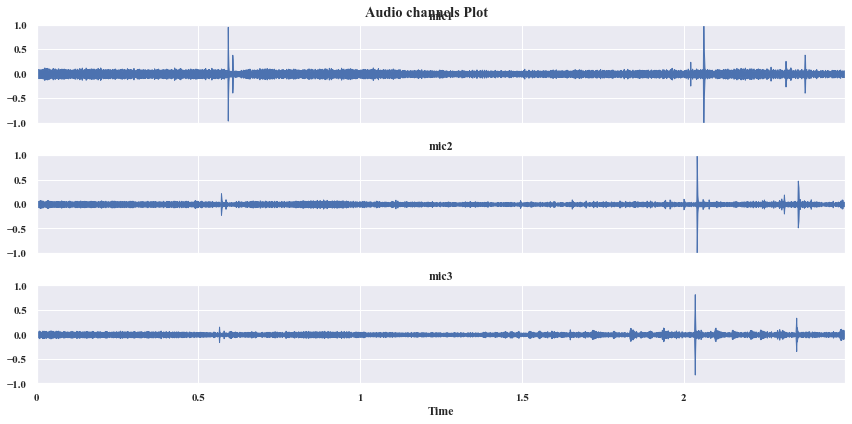

In [51]:
plot_time_domain_all_mic(good_trimmed_trials_all_mic, 10)

In [52]:
IPython.display.Audio(good_trimmed_trials_all_mic[3][0], rate=fs)

In [9]:
# Function to plot time domain for mic1_trim of all trials in a 6x4 grid
def plot_time_domain_all_trial(trimmed_trials_all_mic, fs, success_file_list):
    num_trials = len(trimmed_trials_all_mic)

    fig, axes = plt.subplots(6, 4, figsize=(18, 18))
    fig.suptitle('Audio Channels Plot for All Trials (Mic 1)', y=1.02)

    for row in range(6):
        for col in range(4):
            trial_index = row * 4 + col
            if trial_index < num_trials:
                mic1_trim = trimmed_trials_all_mic[trial_index][0]

                time_axis = np.linspace(0, len(mic1_trim) / fs, len(mic1_trim))

                axes[row, col].plot(time_axis, mic1_trim)
                axes[row, col].set_title(f"Trial {success_file_list[trial_index]}")
                axes[row, col].set_ylim([-1, 1])
                axes[row, col].set_xlabel("Time")  # Add x-axis label

            else:
                axes[row, col].axis('off')  # Turn off empty subplots

    plt.tight_layout()  # Ensure proper spacing between subplots
    plt.show()

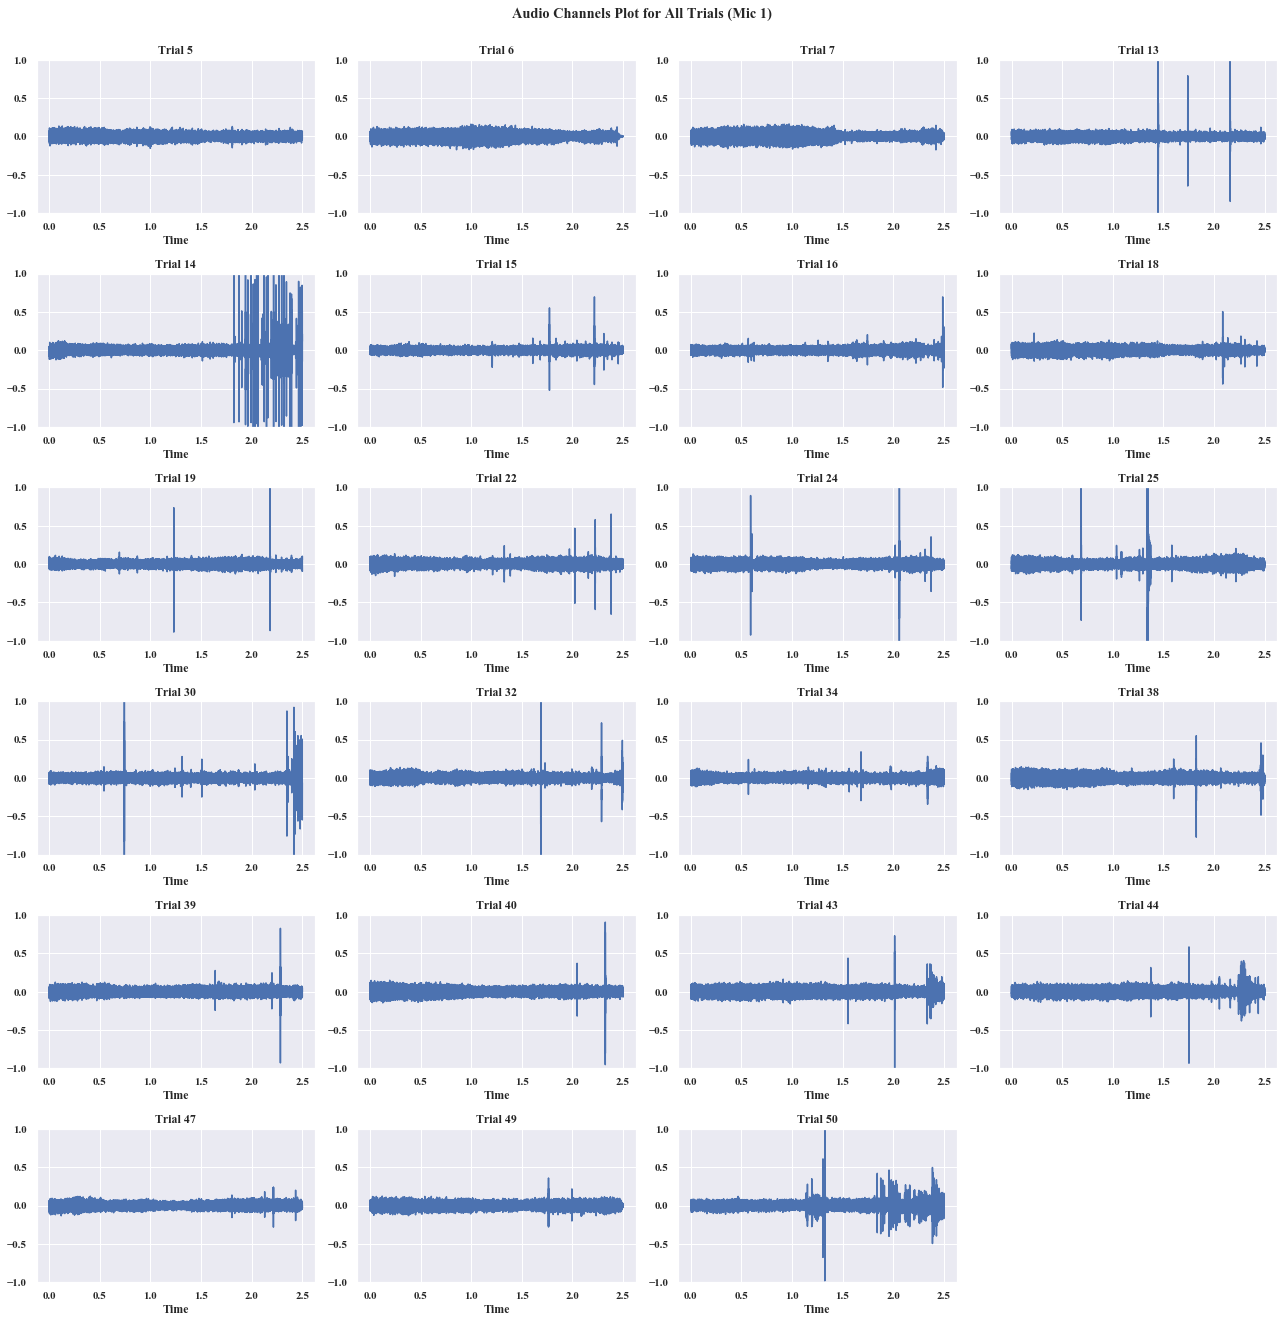

In [14]:
plot_time_domain_all_trial(good_trimmed_trials_all_mic, fs,success_file_list)

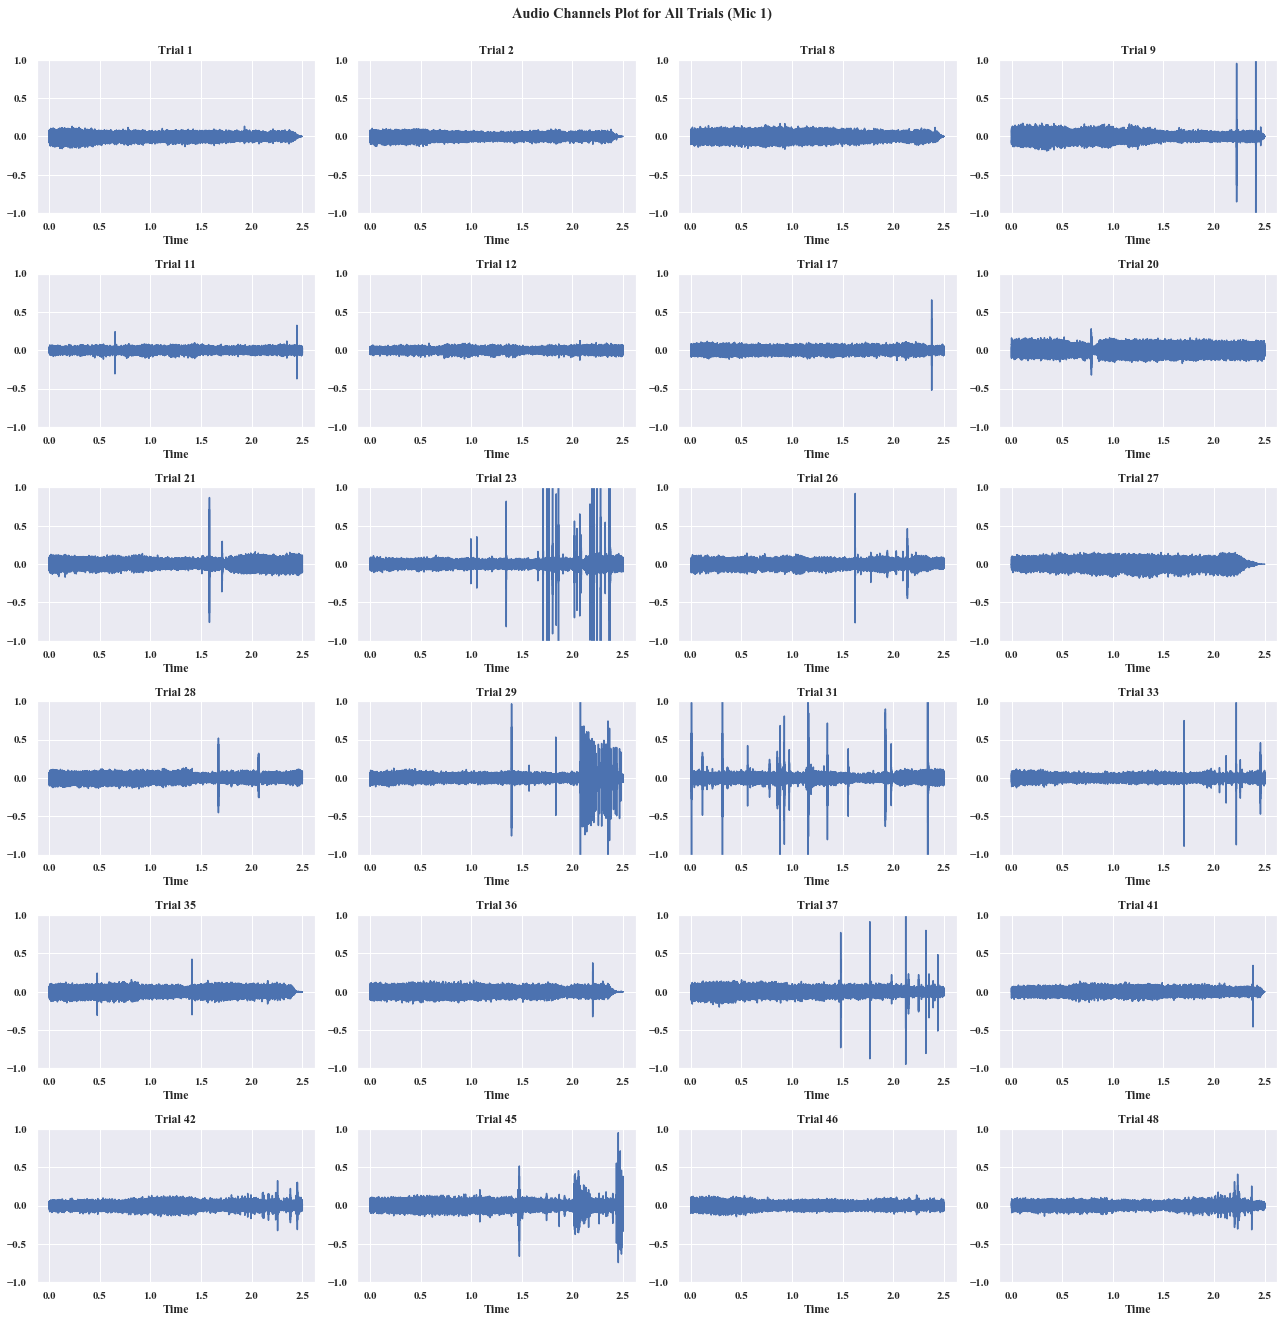

In [15]:
plot_time_domain_all_trial(bad_trimmed_trials_all_mic, fs,fail_file_list)

In [10]:
# Function to plot time domain with good trials on the left column and bad trials on the right column
def plot_time_domain_good_bad(good_trimmed_trials_all_mic, good_trial_index, bad_trials_all_mic, bad_trial_index, fs):
    good_audio_input1_trim = good_trimmed_trials_all_mic[good_trial_index][0]
    good_audio_input2_trim = good_trimmed_trials_all_mic[good_trial_index][1]
    good_audio_input3_trim = good_trimmed_trials_all_mic[good_trial_index][2]
    
    bad_audio_input1_trim = bad_trials_all_mic[bad_trial_index][0]
    bad_audio_input2_trim = bad_trials_all_mic[bad_trial_index][1]
    bad_audio_input3_trim = bad_trials_all_mic[bad_trial_index][2]
    
    time_axis = np.linspace(0, len(good_audio_input1_trim) / fs, len(good_audio_input1_trim))

    fig, axes = plt.subplots(3, 2, figsize=(12, 9))
    fig.suptitle('Audio Channels Plot ')

    # Good Trials (Left Column)
    librosa.display.waveplot(good_audio_input1_trim, sr=fs, ax=axes[0, 0])
    axes[0, 0].set_title("Good mic1")
    axes[0, 0].set_ylim([-1, 1])
    axes[0, 0].xaxis.set_label_text('')
    
    librosa.display.waveplot(good_audio_input2_trim, sr=fs, ax=axes[1, 0])
    axes[1, 0].set_title("Good mic2")
    axes[1, 0].set_ylim([-1, 1])
    axes[1, 0].xaxis.set_label_text('')
    
    librosa.display.waveplot(good_audio_input3_trim, sr=fs, x_axis='time', ax=axes[2, 0])  # Add x_axis='time'
    axes[2, 0].set_title("Good mic3")
    axes[2, 0].set_ylim([-1, 1])
    axes[2, 0].set_xlabel("Time")

    # Bad Trials (Right Column)
    librosa.display.waveplot(bad_audio_input1_trim, sr=fs, ax=axes[0, 1])
    axes[0, 1].set_title("Bad mic1")
    axes[0, 1].set_ylim([-1, 1])
    axes[0, 1].xaxis.set_label_text('')

    librosa.display.waveplot(bad_audio_input2_trim, sr=fs, ax=axes[1, 1])
    axes[1, 1].set_title("Bad mic2")
    axes[1, 1].set_ylim([-1, 1])
    axes[1, 1].xaxis.set_label_text('')

    librosa.display.waveplot(bad_audio_input3_trim, sr=fs, x_axis='time', ax=axes[2, 1])  # Add x_axis='time'
    axes[2, 1].set_title("Bad mic3")
    axes[2, 1].set_ylim([-1, 1])
    axes[2, 1].set_xlabel("Time")

    plt.tight_layout()  # Ensure proper spacing between subplots
    plt.show()

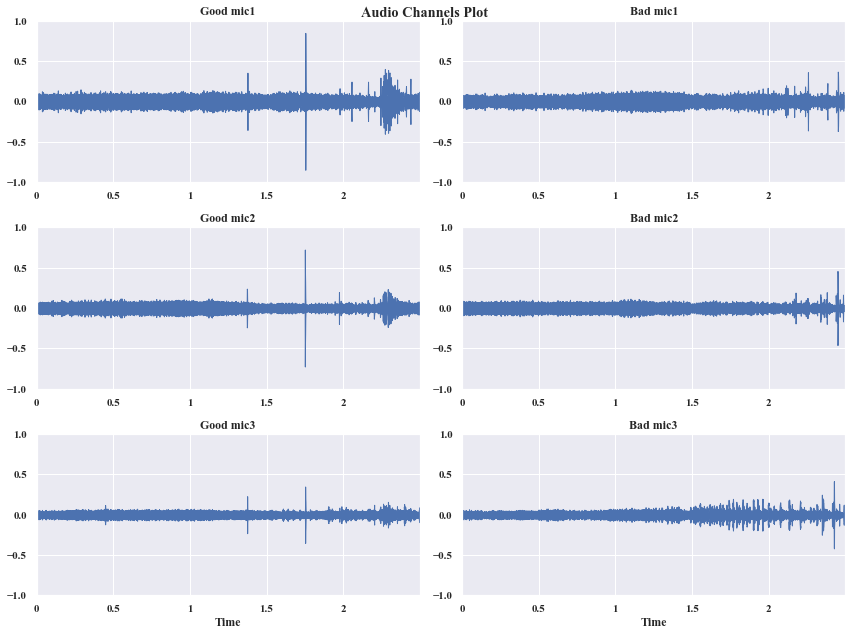

In [55]:
index = -4
plot_time_domain_good_bad(good_trimmed_trials_all_mic, index, bad_trimmed_trials_all_mic, index, fs)


In [56]:
IPython.display.Audio(good_trimmed_trials_all_mic[index][0], rate=fs)

In [57]:
IPython.display.Audio(bad_trimmed_trials_all_mic[index][0], rate=fs)

In [58]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Button
import numpy as np
import librosa

# Function to plot time domain for mic1_trim of all trials in a 6x4 grid
def animate_time_domain_all_trial(trimmed_trials_all_mic, fs, success_file_list):
    num_trials = len(trimmed_trials_all_mic)

    fig, axes = plt.subplots(6, 4, figsize=(18, 18))
    fig.suptitle('Audio Channels Plot for All Trials (Mic 1)', y=1.02)

    def animate_bar(frame):
        ax.bar(frame / fs, 1, color='red')  # Update the position of the bar
        return ax

    def play_audio(event):
        trial_index = int(play_button._label.replace("Play Trial ", ""))
        mic1_trim = trimmed_trials_all_mic[trial_index][0]
        librosa.output.play(mic1_trim, sr=fs)

    for row in range(6):
        for col in range(4):
            trial_index = row * 4 + col
            if trial_index < num_trials:
                mic1_trim = trimmed_trials_all_mic[trial_index][0]
                time_axis = np.linspace(0, len(mic1_trim) / fs, len(mic1_trim))

                ax = axes[row, col]
                line = ax.plot(time_axis, mic1_trim)[0]

                anim = FuncAnimation(fig, animate_bar, frames=np.arange(0, len(time_axis)), blit=True)

                ax.set_title(f"Trial {success_file_list[trial_index]}")
                ax.set_ylim([-1, 1])
                ax.set_xlabel("Time")  # Add x-axis label

                play_button = Button(ax, f"Play Trial {trial_index}", color='lightgoldenrodyellow', hovercolor='0.975')
                play_button.on_clicked(play_audio)

            else:
                axes[row, col].axis('off')  # Turn off empty subplots

    plt.tight_layout()  # Ensure proper spacing between subplots
    plt.show()

Traceback (most recent call last):
  File "/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/matplotlib/animation.py", line 953, in _start
    self._init_draw()
  File "/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/matplotlib/animation.py", line 1732, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/matplotlib/animation.py", line 1761, in _draw_frame
    key=lambda x: x.get_zorder())
TypeError: 'AxesSubplot' object is not iterable
Traceback (most recent call last):
  File "/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/matplotlib/animation.py", line 953, in _start


Traceback (most recent call last):
  File "/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/matplotlib/animation.py", line 953, in _start
    self._init_draw()
  File "/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/matplotlib/animation.py", line 1732, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/matplotlib/animation.py", line 1761, in _draw_frame
    key=lambda x: x.get_zorder())
TypeError: 'AxesSubplot' object is not iterable
Traceback (most recent call last):
  File "/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/matplotlib/animation.py", line 953, in _start


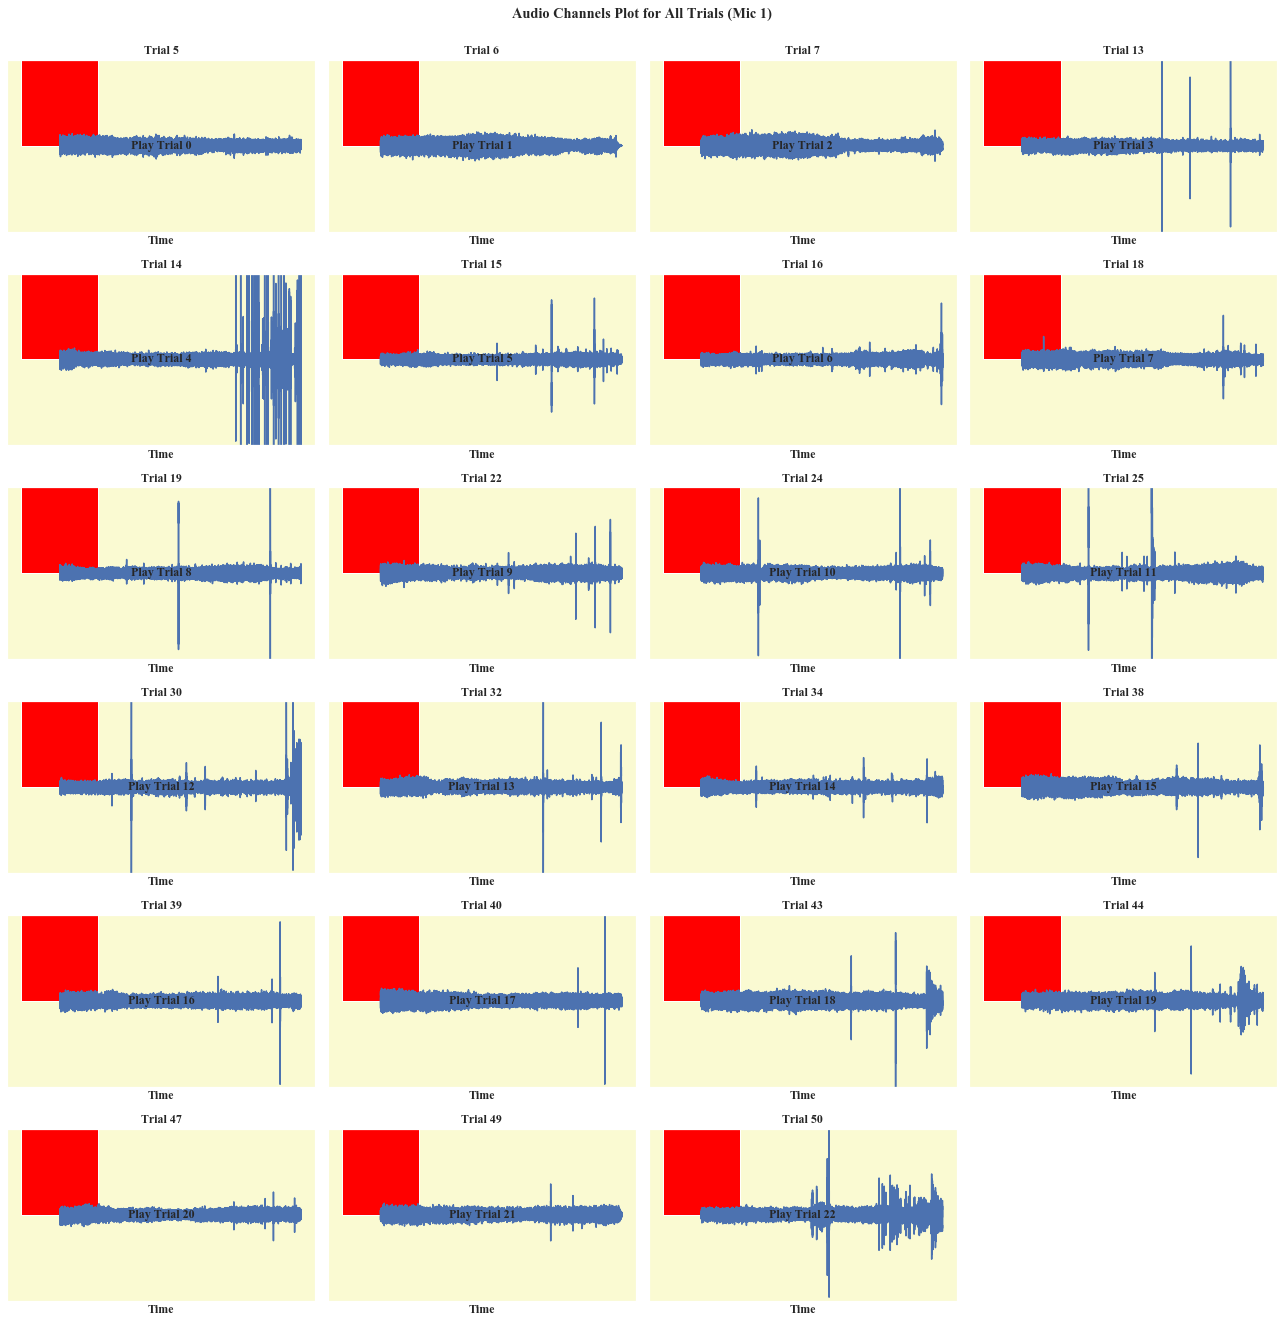

In [59]:
animate_time_domain_all_trial(good_trimmed_trials_all_mic, fs, success_file_list)

In [60]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import ScalarFormatter

# Function to convert audio into spectrogram and subplot all trials in a 6x4 grid
def convert_time_to_spec(input_trimmed_trials_all_mic, in_file_list):
    num_trials = len(input_trimmed_trials_all_mic)
    freq_ticks = [64, 128, 256, 512, 1024, 2048, 4096, 8192]  # Logarithmic frequency ticks


    fig, axes = plt.subplots(6, 4, figsize=(18, 18))
    fig.suptitle('Spectrogram Plot for All Trials (Mic 1)', y=1.02)
    
    S_db_hr_list = []

    for row in range(6):
        for col in range(4):
            trial_index = row * 4 + col
            if trial_index < num_trials:
                audio = input_trimmed_trials_all_mic[trial_index][0]
                D_highres = librosa.stft(audio, hop_length=512, n_fft=2048)
                S_db_hr = librosa.amplitude_to_db(np.abs(D_highres), ref=np.max)
                
                im = axes[row, col].imshow(S_db_hr, origin='lower', aspect='auto', cmap='viridis',
                                           extent=[0, len(audio) / fs, 0, fs / 2])

                axes[row, col].set_title(f"Trial {in_file_list[trial_index]}")
                axes[row, col].set_ylabel("Frequency (Hz)")
                axes[row, col].set_xlabel("Time")

                # Add individual colorbar for each subplot
#                 cbar = fig.colorbar(im, ax=axes[row, col], format='%+2.0f dB')
#                 cbar.set_label('Intensity (dB)', labelpad=10)

                # Hide grid lines
                axes[row, col].grid(False)
        
                # Set y-axis scale to log
                axes[row, col].set_yscale('log')
                axes[row, col].set_yticks(freq_ticks)
                axes[row, col].yaxis.set_major_formatter(ScalarFormatter())  # Use the correct formatter
                axes[row, col].set_ylim([freq_ticks[0], freq_ticks[-1]])  # Set y-axis limits
                
                
                S_db_hr_list.append(S_db_hr)

    
            else:
                axes[row, col].axis('off')  # Turn off empty subplots



    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ensure proper spacing and accommodate colorbar
    plt.show()
    
    return S_db_hr_list


In [61]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import ScalarFormatter

# Function to convert audio into MFCC and subplot all trials in a 6x4 grid
def convert_time_to_mfcc(input_trimmed_trials_all_mic, in_file_list):
    num_trials = len(input_trimmed_trials_all_mic)


    fig, axes = plt.subplots(6, 4, figsize=(18, 18))
    fig.suptitle('MFCC Plot for All Trials (Mic 1)', y=1.02)
    
    mfcc_hr_list = []
    
    max_mfcc_value = 10
    min_mfcc_value = -700

    for row in range(6):
        for col in range(4):
            trial_index = row * 4 + col
            if trial_index < num_trials:
                audio = input_trimmed_trials_all_mic[trial_index][0]
                
                #TODO:
                mfcc_ = librosa.feature.mfcc(y=audio, sr=fs, n_mfcc=12)
                
                 # Update global MFCC scale values
                max_mfcc_value = max(max_mfcc_value, np.max(mfcc_))
                min_mfcc_value = min(min_mfcc_value, np.min(mfcc_))
                
                # Plot the MFCC
                im = axes[row, col].imshow(mfcc_, origin='lower', aspect='auto', cmap='viridis', vmin=min_mfcc_value, vmax=max_mfcc_value)
                
                # Add colorbar
                divider = make_axes_locatable(axes[row, col])
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im, cax=cax, format=ScalarFormatter())
                
                # Hide grid lines
                axes[row, col].grid(False)
                mfcc_hr_list.append(mfcc_)

    
            else:
                axes[row, col].axis('off')  # Turn off empty subplots



    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ensure proper spacing and accommodate colorbar
    plt.show()
    
    return mfcc_hr_list


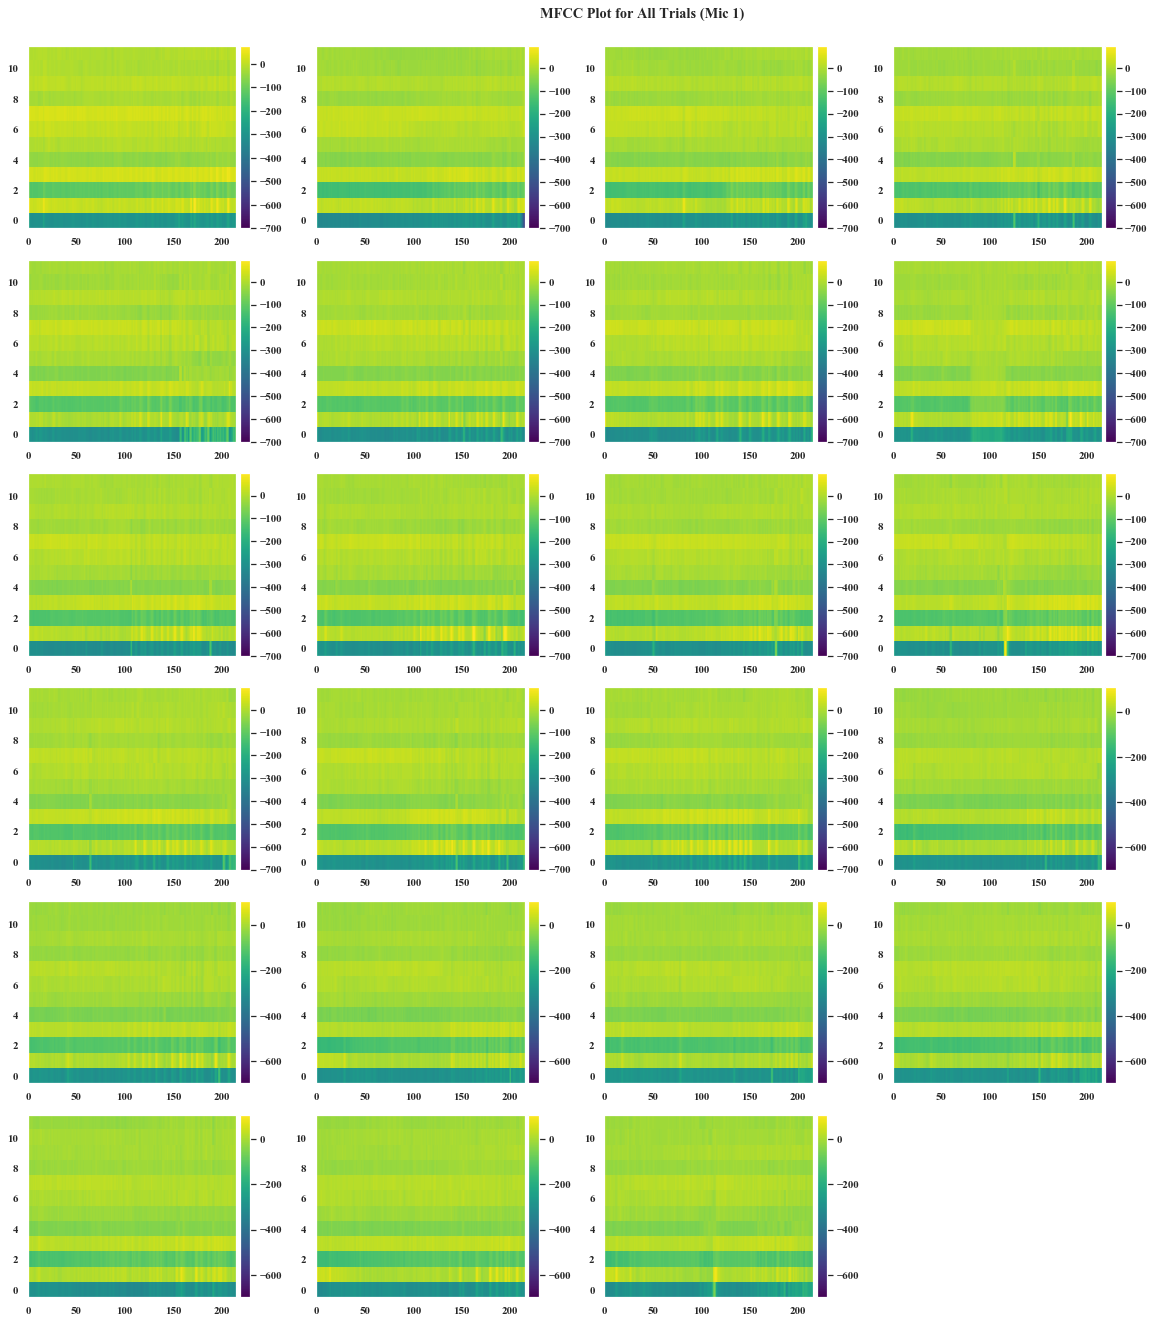

In [62]:
mfcc_list_good = convert_time_to_mfcc(good_trimmed_trials_all_mic, success_file_list)

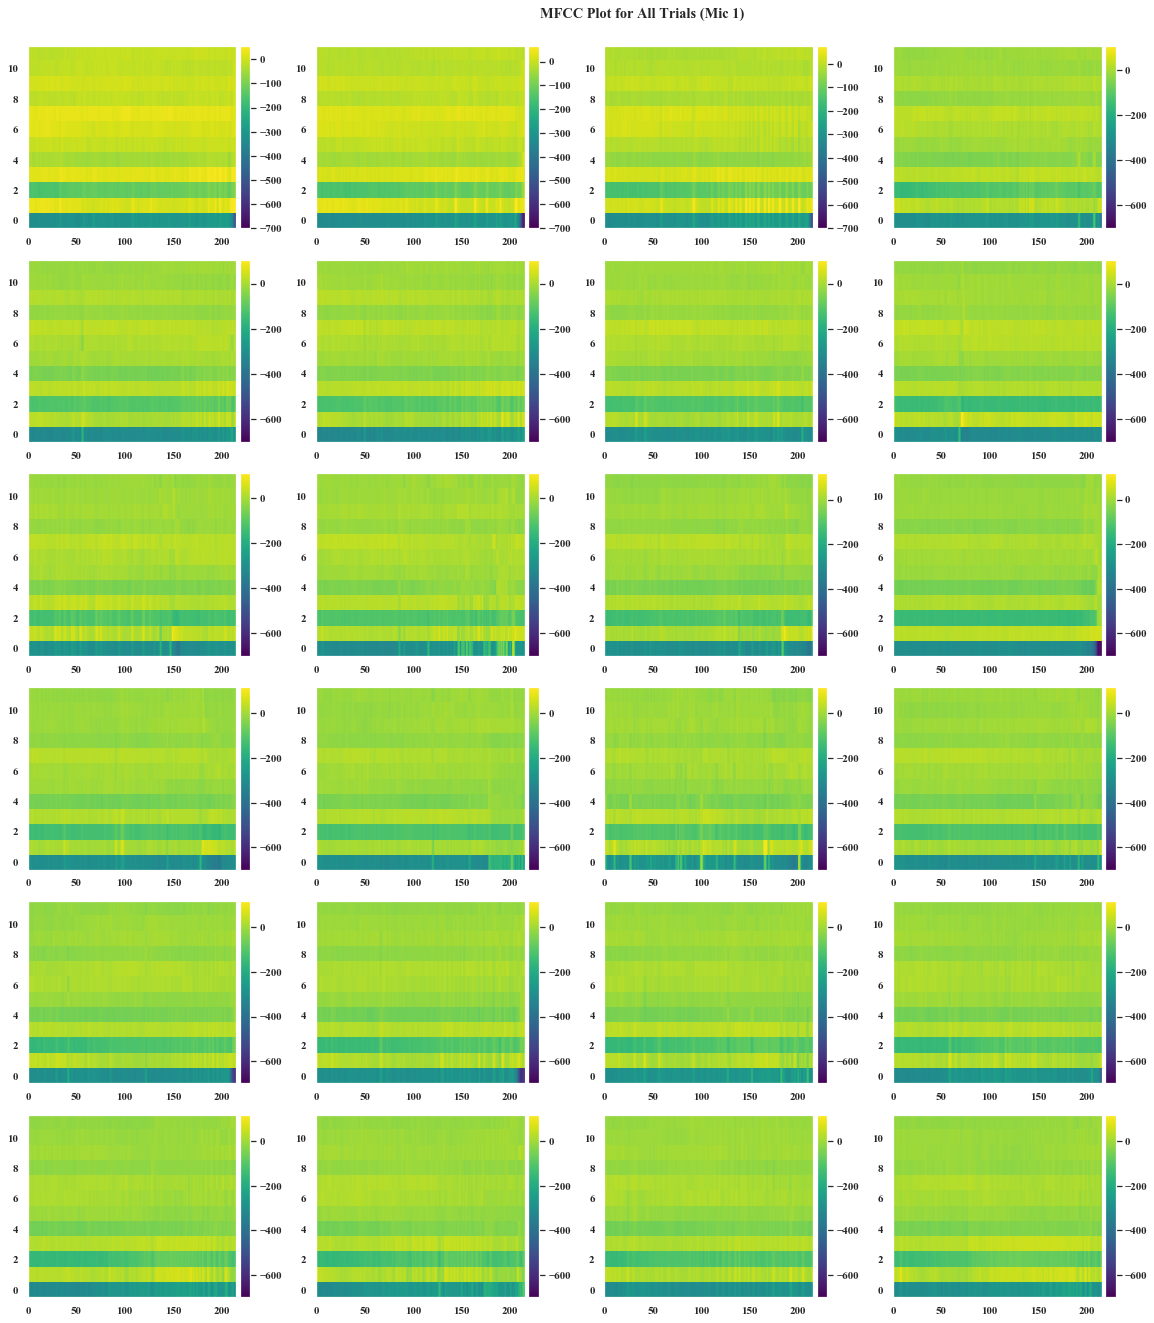

In [63]:
mfcc_list_bad = convert_time_to_mfcc(bad_trimmed_trials_all_mic, fail_file_list)

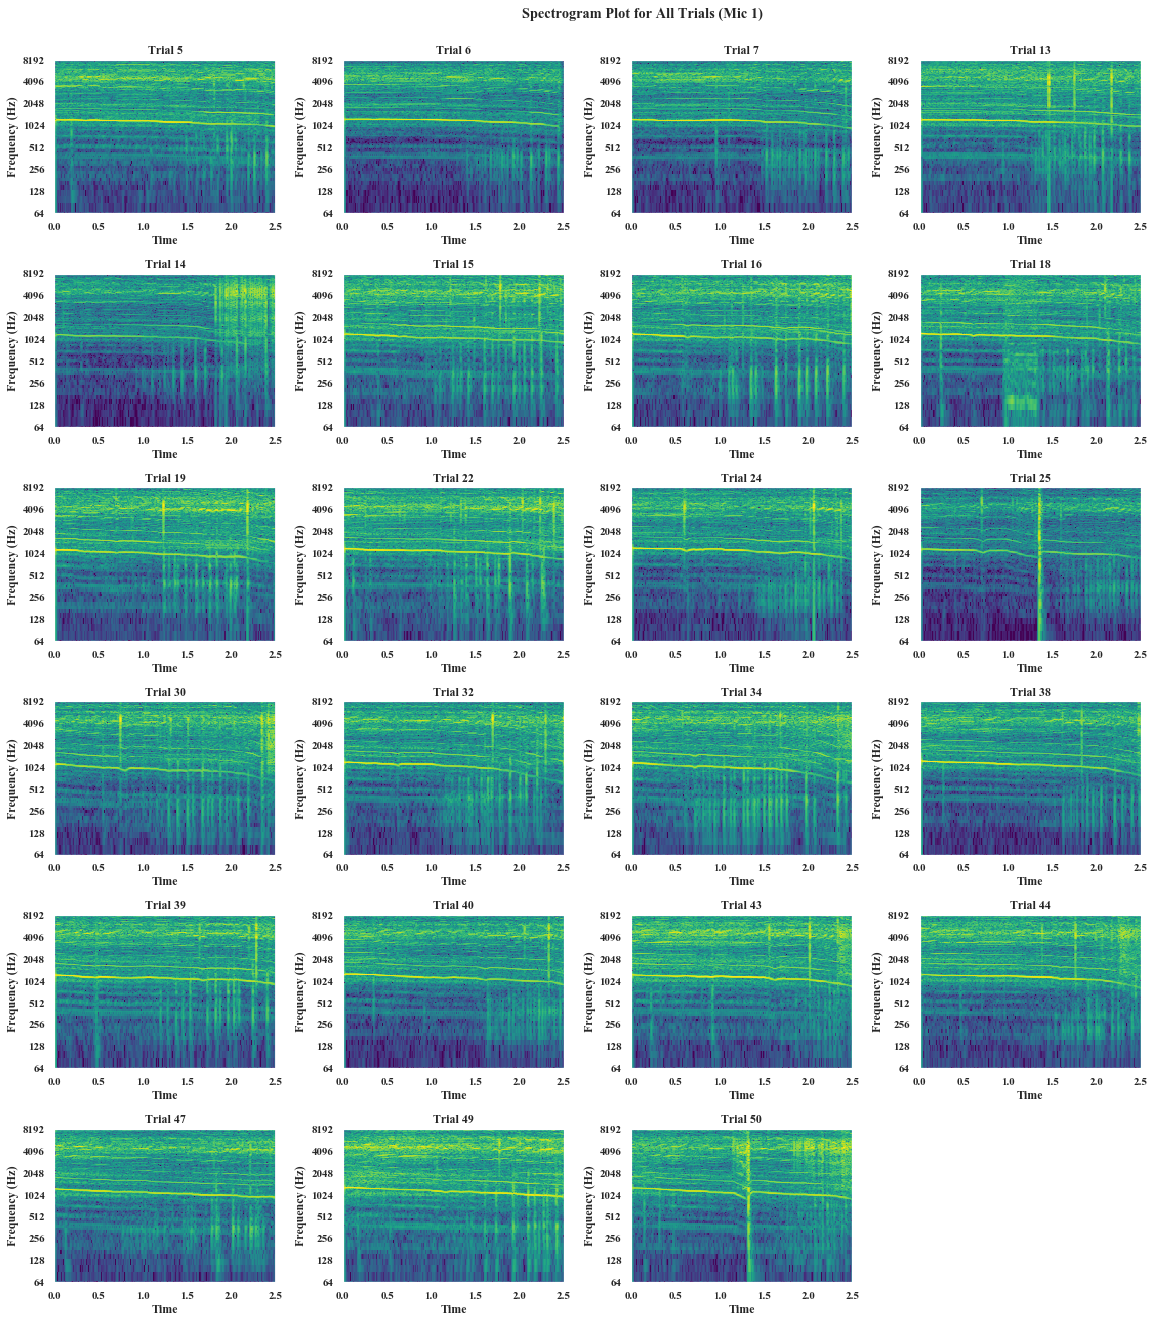

In [64]:
Spec_list_good = convert_time_to_spec(good_trimmed_trials_all_mic, success_file_list)

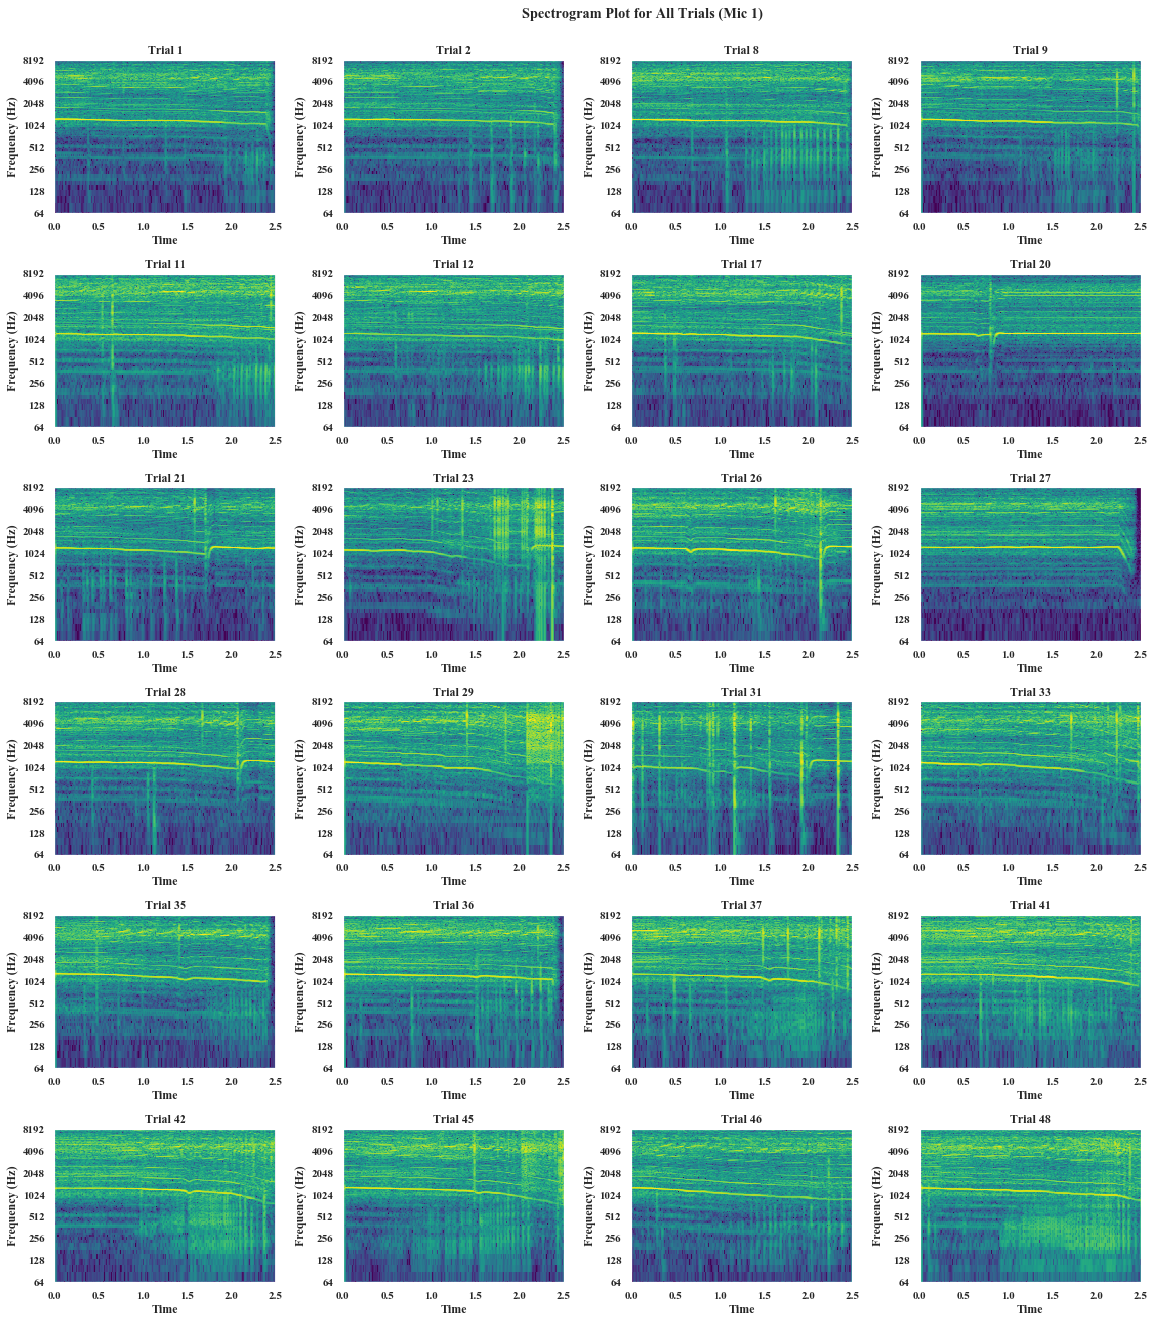

In [65]:
Spec_list_bad = convert_time_to_spec(bad_trimmed_trials_all_mic, fail_file_list)

In [25]:
print(f"{len(Spec_list_good)}, {len(Spec_list_bad)}")
print(f"{Spec_list_good[0].shape}")
print(f"{Spec_list_good[1].shape}")


23, 24
(1025, 108)
(1025, 108)


In [26]:
#function to preprocess input spectrogram for PCA
from IPython.display import display
#normalize before doing PCA
from sklearn.preprocessing import StandardScaler

def preprocess_spectrogram(input_data):
    # Input: list with length N with each item size of (WxH)
    # Output: (N, WxH) numpy array
    
    N = len(input_data)
    WxH = input_data[0].shape[0] * input_data[0].shape[1]
    
    # Reshape into (N, WxH)
    reshaped_data = np.reshape(input_data, (N, WxH))
    
    # Normalize by zero-centering and unit variance
#     mean = np.mean(reshaped_data, axis=0)
#     std = np.std(reshaped_data, axis=0)
#     normalized_data = (reshaped_data - mean) / 1
    
    normalized_data = StandardScaler().fit_transform(reshaped_data)


    return normalized_data

In [41]:
#normalize data
normalized_good_trials = preprocess_spectrogram(Spec_list_good)
normalized_bad_trials = preprocess_spectrogram(Spec_list_bad)

#stack both data
normalized_all_trials = np.vstack((normalized_good_trials, normalized_bad_trials))


print(f" shape {normalized_all_trials.shape}")
print(f"mean: {np.mean(normalized_all_trials[:,0])}, var: {np.var(normalized_all_trials[:,0])}")


 shape (47, 110700)
mean: 5.0727355649371475e-09, var: 0.9999999403953552


In [57]:
#train data
n_index = 18

train_data = np.vstack((normalized_good_trials[:n_index, : ], normalized_bad_trials[:n_index, :]))
test_data = np.vstack((normalized_good_trials[n_index:, : ], normalized_bad_trials[n_index:, :]))

# label data
zeros_array = np.zeros(23)
ones_array = np.ones(24)
scatter_color = np.concatenate((zeros_array, ones_array))

train_label = np.vstack(( zeros_array[:n_index].reshape(-1,1) , ones_array[:n_index].reshape(-1,1) ))
test_label = np.vstack(( zeros_array[n_index:].reshape(-1,1) , ones_array[n_index:].reshape(-1,1) ))

In [59]:
print(f" {train_label.shape}, {test_label.shape} ")
print(f" {train_data.shape}, {test_data.shape} ")

 (36, 1), (11, 1) 
 (36, 110700), (11, 110700) 


In [28]:
#visualize variance info to know how many eigen components
num_features = np.min( (normalized_all_trials.shape[0], normalized_all_trials.shape[1]) )

#how many PCA components?
N_comp = num_features
pca_full_features = PCA(n_components = N_comp)
pca_full_features.fit(normalized_all_trials)


exp_var_pca = pca_full_features.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

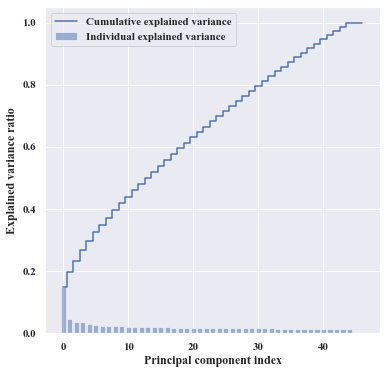

In [29]:
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca[0:N_comp])), exp_var_pca[0:N_comp], alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues[0:N_comp])), cum_sum_eigenvalues[0:N_comp], where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [30]:
#reduce dim with PCA
pca = PCA(2) # we need 2 principal components.
spec_input_pca = pca.fit_transform(normalized_all_trials)
#print out data table shape
print(f"pca shape {spec_input_pca.shape}")

pca shape (47, 2)


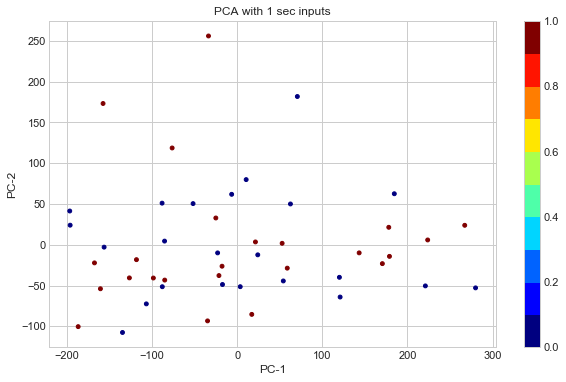

In [32]:
#scatter plot
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(spec_input_pca[:, 0], spec_input_pca[:, 1], s = 15,
            cmap = c_map , c = scatter_color)

plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.title("PCA with 1 sec inputs")

plt.colorbar()
plt.show()

# function to SVM classify

In [60]:
X = normalized_all_trials
y = scatter_color
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=3)

X_train= train_data
X_test = test_data
y_train = train_label
y_test = test_label

print(f"X_train {X_train.shape}, X_test {X_test.shape}, y_train {y_train.shape}, y_test {y_test.shape}")

X_train (36, 110700), X_test (11, 110700), y_train (36, 1), y_test (11, 1)


In [62]:
# Defining the parameters grid for GridSearchCV
param_grid={'C':[0.1,1,10,100],
            'gamma':[0.0001,0.001,0.1,1],
            'kernel':['rbf','poly']}

In [63]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [64]:
from sklearn import svm, metrics
from sklearn.metrics import ConfusionMatrixDisplay

# Creating a support vector classifier
svc=svm.SVC(probability=True)
  
# Creating a model using GridSearchCV with the parameters grid
model=GridSearchCV(svc,param_grid)

#learn to fit
model.fit(X_train,y_train)

#predict based on model
predicted = model.predict(X_test)


/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was pass

/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was pass

/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was pass

/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was pass

/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was pass

/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marklee/anaconda3/envs/audio/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was pass

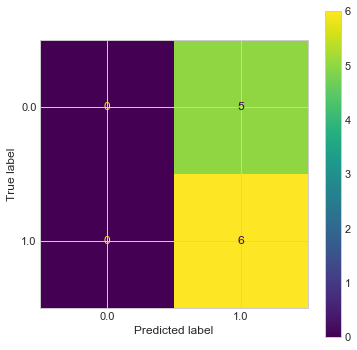

In [65]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cm = confusion_matrix(y_test, predicted, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [40]:
y_test

array([1., 1., 0., 1., 1., 0., 0., 0., 0., 1.])

# example cat vs dog SVM classifier 

https://www.geeksforgeeks.org/image-classification-using-support-vector-machine-svm-in-python/

In [ ]:
Categories=['cats','dogs']
flat_data_arr=[] #input array
target_arr=[] #output array
datadir='/home/marklee/Downloads/archive/dog vs cat/dataset/training_set/' 
#path which contains all the categories of images
for i in Categories:
      
    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(150,150,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
    print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)

In [ ]:
#dataframe
df=pd.DataFrame(flat_data) 
df['Target']=target
df.shape

In [ ]:
#input data 
x=df.iloc[:,:-1] 
#output data
y=df.iloc[:,-1]

In [ ]:
# Splitting the data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)

In [ ]:
# Creating a support vector classifier
svc=svm.SVC(probability=True)
  
# Creating a model using GridSearchCV with the parameters grid
model=GridSearchCV(svc,param_grid)

In [ ]:
# Training the model using the training data
model.fit(x_train,y_train)